Modularize functions for scaling and labeling so easier to test different configurations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn.preprocessing as preprocess
from collections import Counter
import pprint
from scipy.stats import chisquare
import skfuzzy as fuzz


pp = pprint.PrettyPrinter(indent=4)

In [2]:
data = pd.read_csv("TopCharts_unique.csv", index_col = 0)

In [3]:
cluster_df = data.drop(columns = ["Time Signature", "Key", "Mode","Instrumentalness", "Acousticness", "Days"])

In [4]:
def scaleData(scaler, data, firstCol):
    mms = scaler()
    cluster_values = data.iloc[:,firstCol:]
    mms.fit(cluster_values)
    return mms.transform(cluster_values)

In [5]:
data_transformed = scaleData(preprocess.StandardScaler, cluster_df, 3)

In [6]:
def plotKMeans(data, minCluster, maxCluster):
    inertias = []
    for i in range(minCluster, maxCluster):
        kmeans = KMeans(n_clusters = i).fit(data)
        inertias.append(kmeans.inertia_)    
    
    plt.plot(range(1,len(inertias)+1), inertias, "bx-")
    plt.xlabel('k')
    plt.ylabel("Inertia")
    plt.xticks(range(1,len(inertias)+1))
    plt.show()
    
    
    diffs = np.array(inertias[1:]) - np.array(inertias[:len(inertias)-1])
    plt.plot(range(1,len(inertias)+1), [-inertias[0]] + list(diffs),"bx-")
    plt.ylabel("Change in Inertia")
    plt.xticks(range(1,len(inertias)+1))

    plt.show()
    
    return(inertias)
    

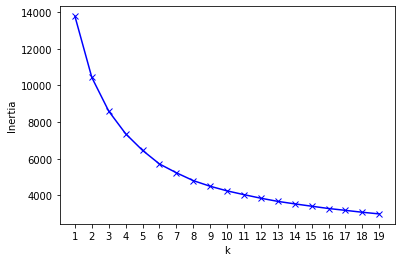

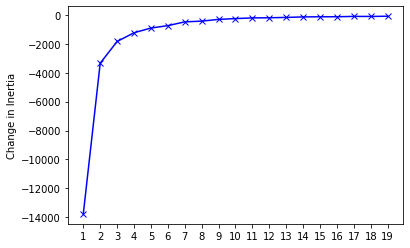

In [7]:
inertias = plotKMeans(data_transformed, 1, 20)

In [8]:
def fitKMeans(data, clusters):
    """
    inputs: data = dataframe of songs
            clusters = number of desired clusters
    returns: groups = dict of dataframes {cluster number: subset of dataframe with songs in this cluster}
             counters = dict of Counters {cluster number: Counter(artist, number of times artist appears in cluster)}
    """
    labels_df = cluster_df.copy()
    kmeans_opt = KMeans(n_clusters = clusters).fit(data)
    labels_df["Label"] = kmeans_opt.labels_
    

    groups ={}
    counters = {}
    for i in range(clusters):
        groups[i] = labels_df[labels_df["Label"] == i]
        counters[i] = Counter(groups[i]["Artist"])
    
    return groups, counters

In [9]:
cluster_df_subset, cluster_artist_counter = fitKMeans(data_transformed, 13)

In [10]:
pp.pprint(cluster_artist_counter)

{   0: Counter({   'Mac Miller': 10,
                   'Khalid': 7,
                   'Post Malone': 5,
                   'Drake': 4,
                   'Taylor Swift': 4,
                   'XXXTENTACION': 4,
                   'Trippie Redd': 4,
                   'Beyoncé': 4,
                   'A$AP Rocky': 4,
                   'Juice WRLD': 4,
                   'Halsey': 3,
                   'Future': 3,
                   'Hozier': 3,
                   'Jon Bellion': 3,
                   'Metro Boomin': 3,
                   'Vampire Weekend': 3,
                   'Bon Iver': 3,
                   'Demi Lovato': 2,
                   'NAV': 2,
                   'Childish Gambino': 2,
                   'Shawn Mendes': 2,
                   'ZAYN': 2,
                   'Martin Garrix': 2,
                   'Julia Michaels': 2,
                   'Thomas Rhett': 2,
                   '6LACK': 2,
                   'Luke Combs': 2,
                   'Tory Lanez': 2,
  

                   'Shoreline Mafia': 1,
                   'Jeremy Zucker': 1,
                   'Flyboy Tarantino': 1,
                   'Vampire Weekend': 1,
                   'Kacey Musgraves': 1,
                   'Lil Nas X': 1,
                   'Polo G': 1,
                   'MEDUZA': 1,
                   'Lil Tecca': 1,
                   'Shordie Shordie': 1,
                   'Ali Gatie': 1,
                   'Tom Petty': 1,
                   'John Mellencamp': 1,
                   'Majid Jordan': 1,
                   'Clairo': 1,
                   'The Lumineers': 1,
                   'Harry Styles': 1,
                   'JP Saxe': 1,
                   'Josh Gad': 1}),
    4: Counter({   'Juice WRLD': 8,
                   'Post Malone': 7,
                   'Trippie Redd': 7,
                   'Drake': 6,
                   'The Chainsmokers': 6,
                   'Logic': 5,
                   'TOOL': 5,
                   'Marshmello': 4,
             

                    'Lil Baby': 3,
                    'BROCKHAMPTON': 3,
                    'Lil Wayne': 3,
                    'Gunna': 3,
                    'Anderson .Paak': 3,
                    'Blueface': 3,
                    'Mustard': 3,
                    'Jonas Brothers': 3,
                    'Roddy Ricch': 3,
                    'Dreamville': 3,
                    'Melanie Martinez': 3,
                    'Marshmello': 2,
                    'NF': 2,
                    'Halsey': 2,
                    'Ed Sheeran': 2,
                    'Travis Scott': 2,
                    'Yo Gotti': 2,
                    'A Boogie Wit da Hoodie': 2,
                    'Zedd': 2,
                    'Shawn Mendes': 2,
                    'Playboi Carti': 2,
                    'Quality Control': 2,
                    'Bad Bunny': 2,
                    'Ozuna': 2,
                    'Lauv': 2,
                    'Tee Grizzley': 2,
                    'Juice WRLD': 2,
   

In [11]:
def getClusterSongs(cluster_num, groups, counters, artists = [], n_artists = 3):
    """
    inputs: cluster_num = index of cluster
            groups = dict of dataframes {cluster number: subset of dataframe with songs in this cluster}    
            counters = dict of Counters {cluster number: Counter(artist, number of times artist appears in cluster)}
            artists = *optional (don't use if n_artists argument passed)*, which artists to consider
            n_artists = *optional (don't use if artists argument passed)*, how many artists to consider
           
    returns: dict {artist: [list of artist's songs in cluster]}
    """ 
    cnt = counters[cluster_num]
    grp = groups[cluster_num]
    artsong = {}
    if artists:
        assert(set(artists).issubset(set(cnt.keys())))
    else:
        n_artists = min(n_artists, len(cnt.keys()))
        artists = [a[0] for a in cnt.most_common(n_artists)]
    for artist in artists:
        artsong[artist] = list(grp[grp["Artist"] == artist]["Title"])
    return artsong

In [13]:
pp.pprint(getClusterSongs(1, cluster_df_subset, cluster_artist_counter))

{   'DaBaby': [   'Suge',
                  'Goin Baby',
                  'BOP',
                  'RAW SHIT (feat. Migos)',
                  'POP STAR (feat. Kevin Gates)',
                  'PROLLY HEARD',
                  'THERE HE GO'],
    'Ed Sheeran': [   'Shape of You',
                      'Galway Girl',
                      "I Don't Care (with Justin Bieber)",
                      'Cross Me (feat. Chance the Rapper & PnB Rock)',
                      'Remember The Name (feat. Eminem & 50 Cent)',
                      'Nothing On You (feat. Paulo Londra & Dave)'],
    'Logic': [   'Contra',
                 'Indica Badu',
                 'The Return',
                 'Everybody Dies',
                 '100 Miles and Running (ft. Wale & John Lindahl)',
                 'Wu Tang Forever (ft. Ghostface Killah, Raekwon, RZA, Method '
                 'Man, Inspectah Deck, Cappadonna, Jackpot Scotty Wotty, '
                 'U-God, Masta Killa, GZA)',
                 'YSI

In [14]:
artist_json = pd.read_json("groupedArtistData.json")

In [15]:
artist_data = artist_json.transpose()

In [16]:
def getClusterGenres(artist_counter, artist_genre_df):
    """
    inputs: artist_genre_df = dataframe of artist info with artist's genres
            artist_counters = dict of Counters {cluster number: Counter(artist, number of times artist appears in cluster)}
    returns: genre_clusters: dict of dicts {cluster number: {genre: counts}}
             most_freq: dict {cluster number: [genre with highest count, count]}
    """
    genre_clusters = dict() #cluster num, artist genres
    most_freq = dict() #cluster num, most freq genre
    for i in artist_counter.keys():
        cluster_artist = artist_counter[i]
        cluster_genres = []
        for k in cluster_artist.keys():
            try:
                g = artist_genre_df.loc[k, "Genres"]
                for _ in range(cluster_artist[k]):
                    cluster_genres.extend(g)
            except:
                print(f"{k} is not in artist_data")

        cluster_cnt = Counter(cluster_genres) 
        genre_clusters[i] = dict(sorted(cluster_cnt.items()))
        most_freq[i] = cluster_cnt.most_common(1)
    return (genre_clusters, most_freq)

In [17]:
cluster_genre_counts_raw, cluster_classes = getClusterGenres(cluster_artist_counter, artist_data)

Ray Parker, Jr. is not in artist_data
The Black Eyed Peas is not in artist_data
ToKeith is not in artist_data
Bob"Boris" Pickett is not in artist_data
BobHelms is not in artist_data
BaKeem is not in artist_data
Yung Anime is not in artist_data
Lil Monet is not in artist_data
Lil Adrei is not in artist_data
The 7 Dimensions is not in artist_data
GabBarrett is not in artist_data


In [18]:
pp.pprint(cluster_classes)

{   0: [('pop', 141)],
    1: [('pop', 212)],
    2: [('pop', 244)],
    3: [('pop', 149)],
    4: [('pop', 93)],
    5: [('rap', 336)],
    6: [('rap', 18)],
    7: [('pop', 100)],
    8: [('pop', 153)],
    9: [('pop', 210)],
    10: [('pop', 243)],
    11: [('rap', 328)],
    12: [('rap', 200)]}


In [19]:
pp.pprint(cluster_genre_counts_raw)

{   0: {   'adult standards': 8,
           'country': 10,
           'edm': 3,
           'hip hop': 59,
           'house': 3,
           'indie': 14,
           'latin': 1,
           'other': 7,
           'pop': 141,
           'r&b': 23,
           'rap': 84,
           'rock': 18,
           'trap': 38},
    1: {   'adult standards': 8,
           'country': 11,
           'edm': 16,
           'hip hop': 107,
           'house': 19,
           'indie': 10,
           'latin': 31,
           'other': 11,
           'pop': 212,
           'r&b': 8,
           'rap': 155,
           'rock': 32,
           'trap': 91},
    2: {   'adult standards': 1,
           'country': 11,
           'edm': 23,
           'hip hop': 105,
           'house': 28,
           'indie': 14,
           'latin': 2,
           'other': 10,
           'pop': 244,
           'r&b': 30,
           'rap': 168,
           'rock': 31,
           'trap': 79},
    3: {   'adult standards': 32,
           'count

In [20]:
def getTotalGenreCounts(artist_df):
    """
    inputs: artist_df = dataframe of artist info with artist's genres
    returns: dict {genre: counts of number of times genre appears in artist_df}
    """
    l = []
    for g in artist_df.Genres:
        l.extend(g)

    return dict(sorted(Counter(l).items()))

In [21]:
total_genre_counts = getTotalGenreCounts(artist_data)

In [22]:
pp.pprint(total_genre_counts)

{   'adult standards': 35,
    'country': 51,
    'edm': 43,
    'hip hop': 139,
    'house': 51,
    'indie': 48,
    'latin': 26,
    'other': 49,
    'pop': 383,
    'r&b': 42,
    'rap': 215,
    'rock': 101,
    'trap': 124}


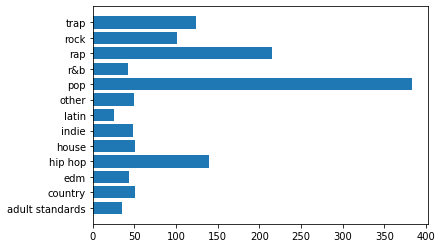

In [23]:
plt.barh(range(0,len(total_genre_counts.keys())), total_genre_counts.values())
plt.yticks(range(0,len(total_genre_counts.keys())), total_genre_counts.keys())
plt.show()


In [24]:
all_genres = list(total_genre_counts.keys())

In [25]:
def convertCountstoProps(counts_dict):
    """
    input: dict {genre: counts of number of times genre appears in artist_df}
    returns: dict {genre: proportion of number of times genre appears in artist_df}
    """
    
    tc = sum(counts_dict.values())
    props = dict()
    for k in counts_dict.keys():
        props[k] = counts_dict[k]/tc
    cnt = Counter(props)
    return dict(sorted(cnt.items()))

In [26]:
total_genre_props = convertCountstoProps(total_genre_counts)

In [27]:
pp.pprint(total_genre_props)

{   'adult standards': 0.026778882938026015,
    'country': 0.03902065799540933,
    'edm': 0.03289977046671767,
    'hip hop': 0.1063504208110176,
    'house': 0.03902065799540933,
    'indie': 0.036725325172149964,
    'latin': 0.019892884468247895,
    'other': 0.03749043611323642,
    'pop': 0.2930374904361132,
    'r&b': 0.032134659525631215,
    'rap': 0.16449885233358838,
    'rock': 0.0772762050497322,
    'trap': 0.09487375669472073}


In [28]:
def getClusterProps(cluster_counts_dict):
    """
    input: dict of Counters {} of genre counts in each cluster
    returns: dict of Counters of genre proportions in each cluster
    """
    return {list(cluster_counts_dict.keys())[i]:               \
            convertCountstoProps(cluster_counts_dict[i]) \
            for i in list(cluster_counts_dict.keys())}


In [29]:
def alignClusterGenres(cluster_counts_dict, all_genres):
    """
    input:    dict of Counters of genre counts in each cluster;
              list of all possible genres in entire dataset 
    output:   dict of Counters of genre counts in each cluster
    purpose:  ensures that all genres in dataset appear in cluster; if 
              a genre is missing from the cluster, add the genre to the cluster
              with value 0
    """
    all_keys = set(all_genres)
    for i in cluster_counts_dict.keys():
        cluster = cluster_counts_dict[i]
        cluster_keys = cluster.keys()
        for k in all_keys - cluster_keys:
            cluster[k] = 0
    return cluster_counts_dict 

In [30]:
cluster_genre_counts = alignClusterGenres(cluster_genre_counts_raw, all_genres)

In [31]:
pp.pprint(cluster_genre_counts)

{   0: {   'adult standards': 8,
           'country': 10,
           'edm': 3,
           'hip hop': 59,
           'house': 3,
           'indie': 14,
           'latin': 1,
           'other': 7,
           'pop': 141,
           'r&b': 23,
           'rap': 84,
           'rock': 18,
           'trap': 38},
    1: {   'adult standards': 8,
           'country': 11,
           'edm': 16,
           'hip hop': 107,
           'house': 19,
           'indie': 10,
           'latin': 31,
           'other': 11,
           'pop': 212,
           'r&b': 8,
           'rap': 155,
           'rock': 32,
           'trap': 91},
    2: {   'adult standards': 1,
           'country': 11,
           'edm': 23,
           'hip hop': 105,
           'house': 28,
           'indie': 14,
           'latin': 2,
           'other': 10,
           'pop': 244,
           'r&b': 30,
           'rap': 168,
           'rock': 31,
           'trap': 79},
    3: {   'adult standards': 32,
           'count

In [32]:
cluster_genre_props = getClusterProps(cluster_genre_counts)
#dict of Counters of genre proportions in each cluster

In [33]:
pp.pprint(cluster_genre_props)

{   0: {   'adult standards': 0.019559902200488997,
           'country': 0.02444987775061125,
           'edm': 0.007334963325183374,
           'hip hop': 0.14425427872860636,
           'house': 0.007334963325183374,
           'indie': 0.034229828850855744,
           'latin': 0.0024449877750611247,
           'other': 0.017114914425427872,
           'pop': 0.34474327628361856,
           'r&b': 0.05623471882640587,
           'rap': 0.20537897310513448,
           'rock': 0.044009779951100246,
           'trap': 0.09290953545232274},
    1: {   'adult standards': 0.011251758087201125,
           'country': 0.015471167369901548,
           'edm': 0.02250351617440225,
           'hip hop': 0.15049226441631505,
           'house': 0.026722925457102673,
           'indie': 0.014064697609001406,
           'latin': 0.04360056258790436,
           'other': 0.015471167369901548,
           'pop': 0.2981715893108298,
           'r&b': 0.011251758087201125,
           'rap': 0.21800281293

In [34]:
def propDiff(overall_props, cluster_props):
    """
    inputs: Counter of proportions of artist genres in overall dataset; 
            Counter of proportions of artist genres in single cluster
    output: Counter of absolute differences in artist genre proportions between
            single cluster and overall dataset 
    """
    return {k:float(cluster_props[k] - overall_props[k]) \
            for k in overall_props.keys()}

In [35]:
def getPropDiffs(overall_props, cluster_props_dict):
    out = dict()
    for i in cluster_props_dict.keys():
        out[i] = propDiff(overall_props, cluster_props_dict[i])
    return out
    

In [36]:
prop_diffs = getPropDiffs(total_genre_props, cluster_genre_props)
pp.pprint(prop_diffs)

{   0: {   'adult standards': -0.007218980737537017,
           'country': -0.014570780244798083,
           'edm': -0.0255648071415343,
           'hip hop': 0.037903857917588754,
           'house': -0.03168569467022596,
           'indie': -0.0024954963212942202,
           'latin': -0.01744789669318677,
           'other': -0.02037552168780855,
           'pop': 0.05170578584750535,
           'r&b': 0.024100059300774655,
           'rap': 0.0408801207715461,
           'rock': -0.03326642509863196,
           'trap': -0.0019642212423979927},
    1: {   'adult standards': -0.01552712485082489,
           'country': -0.023549490625507784,
           'edm': -0.010396254292315422,
           'hip hop': 0.04414184360529745,
           'house': -0.012297732538306658,
           'indie': -0.022660627563148558,
           'latin': 0.023707678119656465,
           'other': -0.022019268743334874,
           'pop': 0.005134098874716608,
           'r&b': -0.02088290143843009,
           'rap

In [37]:
{i:Counter(prop_diffs[i]).most_common(1)for i in prop_diffs.keys()}

{0: [('pop', 0.05170578584750535)],
 1: [('rap', 0.05350396060593343)],
 2: [('rap', 0.06070222005247061)],
 3: [('pop', 0.06599865414220002)],
 4: [('rap', 0.09402387493913891)],
 5: [('rap', 0.13127579555373556)],
 6: [('trap', 0.08461342279245876)],
 7: [('pop', 0.08719064644601604)],
 8: [('rap', 0.052463672321243965)],
 9: [('pop', 0.031537470924010436)],
 10: [('rap', 0.09448503862056282)],
 11: [('rap', 0.1273160942856287)],
 12: [('hip hop', 0.11098291252231572)]}

In [38]:
def chisqTest(overall_props, cluster_counts):
    
    total = sum(cluster_counts.values())
    
    exp = np.array(list(overall_props.values())) * total
    obs = np.array(list(cluster_counts.values()))
    return chisquare(f_obs = obs, f_exp = exp)
    

In [39]:
def classify_chisq(overall_props, cluster_counts_dict, cluster_props_dict, cluster_diffs):
    out = dict()
    for i in cluster_counts_dict.keys():
        d = dict()
        cluster = cluster_counts_dict[i]
        results = chisqTest(overall_props, cluster)
        if results[1] <= .01:
            genre = max(cluster_diffs[i], key = cluster_diffs[i].get)
            d["Genre"] = genre
            d["Proportion"] = cluster_props_dict[i][genre]
            d["Counts"] = cluster_counts_dict[i][genre]
        else:
            mc = Counter(cluster).most_common(1) 
            d["Genre"] = mc[0]
            d["Proportion"] = cluster_props_dict[i][mc[0]]
            d["Counts"] = mc[1]
        out[i] = d
    return out
                    
        
        

In [40]:
convertCountstoProps(cluster_genre_counts[1])

{'adult standards': 0.011251758087201125,
 'country': 0.015471167369901548,
 'edm': 0.02250351617440225,
 'hip hop': 0.15049226441631505,
 'house': 0.026722925457102673,
 'indie': 0.014064697609001406,
 'latin': 0.04360056258790436,
 'other': 0.015471167369901548,
 'pop': 0.2981715893108298,
 'r&b': 0.011251758087201125,
 'rap': 0.2180028129395218,
 'rock': 0.0450070323488045,
 'trap': 0.1279887482419128}

In [41]:
prop_diffs[1]

{'adult standards': -0.01552712485082489,
 'country': -0.023549490625507784,
 'edm': -0.010396254292315422,
 'hip hop': 0.04414184360529745,
 'house': -0.012297732538306658,
 'indie': -0.022660627563148558,
 'latin': 0.023707678119656465,
 'other': -0.022019268743334874,
 'pop': 0.005134098874716608,
 'r&b': -0.02088290143843009,
 'rap': 0.05350396060593343,
 'rock': -0.032269172700927704,
 'trap': 0.03311499154719208}

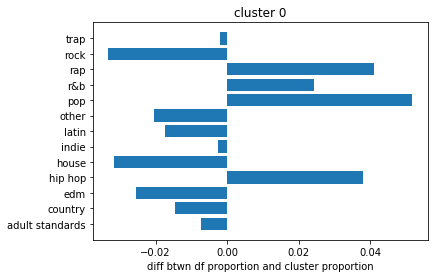

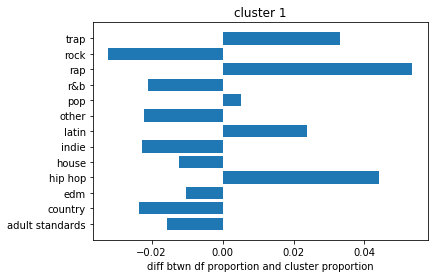

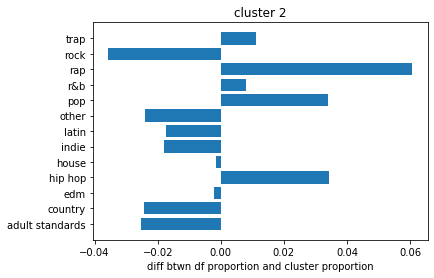

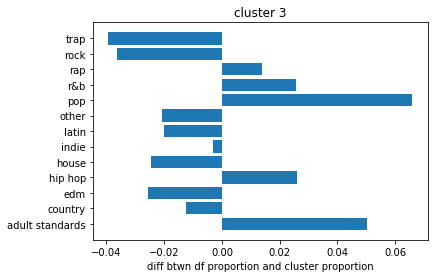

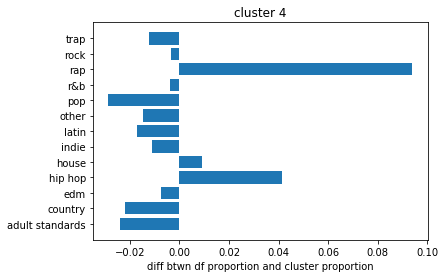

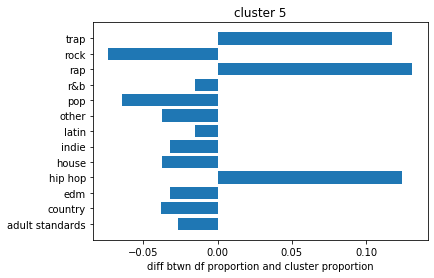

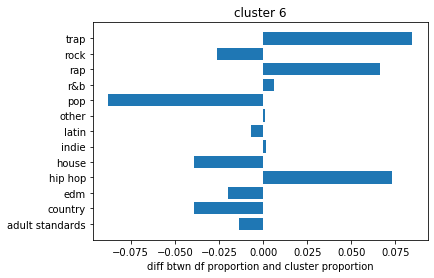

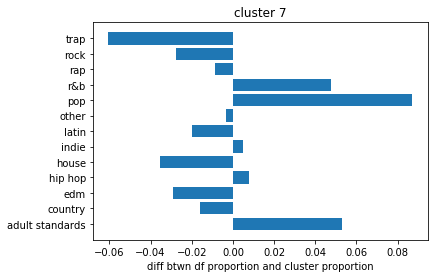

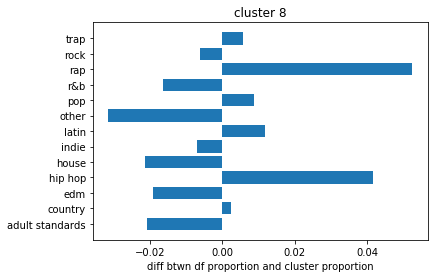

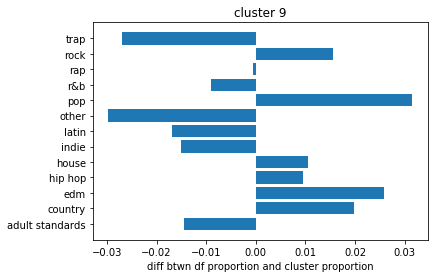

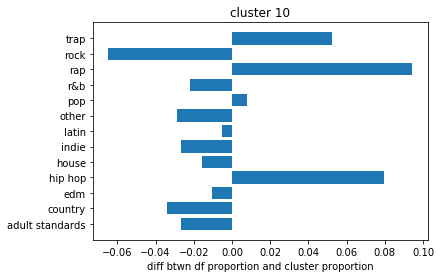

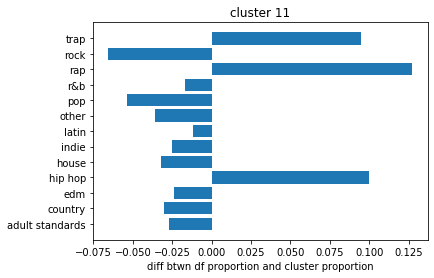

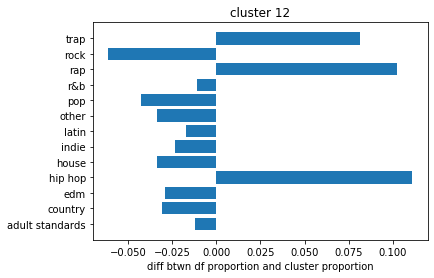

In [42]:
for i in prop_diffs.keys():
    plt.barh(range(0,len(prop_diffs[i].keys())), prop_diffs[i].values())
    plt.yticks(range(0,len(prop_diffs[i].keys())), prop_diffs[i].keys())
    plt.title(f"cluster {i}")
    plt.xlabel("diff btwn df proportion and cluster proportion")
    plt.show()


In [43]:
pp.pprint(classify_chisq(total_genre_props, cluster_genre_counts, cluster_genre_props, prop_diffs))

{   0: {'Counts': 141, 'Genre': 'pop', 'Proportion': 0.34474327628361856},
    1: {'Counts': 155, 'Genre': 'rap', 'Proportion': 0.2180028129395218},
    2: {'Counts': 168, 'Genre': 'rap', 'Proportion': 0.225201072386059},
    3: {'Counts': 149, 'Genre': 'pop', 'Proportion': 0.35903614457831323},
    4: {'Counts': 91, 'Genre': 'rap', 'Proportion': 0.2585227272727273},
    5: {'Counts': 336, 'Genre': 'rap', 'Proportion': 0.29577464788732394},
    6: {'Counts': 14, 'Genre': 'trap', 'Proportion': 0.1794871794871795},
    7: {'Counts': 100, 'Genre': 'pop', 'Proportion': 0.38022813688212925},
    8: {'Counts': 110, 'Genre': 'rap', 'Proportion': 0.21696252465483234},
    9: {'Counts': 210, 'Genre': 'pop', 'Proportion': 0.32457496136012365},
    10: {'Counts': 209, 'Genre': 'rap', 'Proportion': 0.2589838909541512},
    11: {'Counts': 328, 'Genre': 'rap', 'Proportion': 0.2918149466192171},
    12: {'Counts': 163, 'Genre': 'hip hop', 'Proportion': 0.21733333333333332}}


In [44]:
cluster_artist_counter[1]

Counter({'G-Eazy': 2,
         'Lil Pump': 1,
         'Camila Cabello': 2,
         'Lil Uzi Vert': 4,
         'Dua Lipa': 2,
         '21 Savage': 1,
         'Migos': 2,
         'Famous Dex': 1,
         'Logic': 11,
         'Kodak Black': 1,
         'Maroon 5': 1,
         'Luis Fonsi': 1,
         'Portugal. The Man': 1,
         'Marshmello': 1,
         'Hailee Steinfeld': 1,
         'Ed Sheeran': 6,
         'Gucci Mane': 1,
         'Imagine Dragons': 1,
         'Eminem': 5,
         'French Montana': 4,
         'Drake': 1,
         'Taylor Swift': 3,
         'Charlie Puth': 2,
         'XXXTENTACION': 3,
         'Calvin Harris': 2,
         'J Balvin': 5,
         'A Boogie Wit da Hoodie': 2,
         '6ix9ine': 5,
         'Future': 3,
         'Michael Jackson': 2,
         'Bruno Mars': 2,
         'Shawn Mendes': 2,
         'BTS': 5,
         'Big Shaq': 1,
         'KYLE': 1,
         'Foster The People': 2,
         'The Jackson 5': 1,
         'Rich The Kid':

For each cluster, drop genres that are less represented than expected (genres with negative prop diff), cluster again on the 

In [64]:
cluster_df

,Artist,Title,Id,Tempo,Valence,Danceability,Energy
0,Post Malone,rockstar,0e7ipj03S05BNilyu5bRzt,159.801,0.129,0.585,0.520
1,Post Malone,I Fall Apart,75ZvA4QfFiZvzhj2xkaWAh,143.950,0.291,0.556,0.538
2,Post Malone,Candy Paint,32lItqlMi4LBhb4k0BaSaC,180.064,0.381,0.664,0.667
3,Post Malone,Congratulations,3a1lNhkSLSkpJE4MSHpDu9,123.146,0.492,0.630,0.804
4,Post Malone,Go Flex,5yuShbu70mtHXY0yLzCQLQ,81.967,0.127,0.665,0.498
...,...,...,...,...,...,...,...
3437,K CAMP,Lottery (Renegade),4dZTZbmJBCCofAExHwefda,148.964,0.670,0.915,0.556
3438,The 7 Dimensions,Faygo,NaN,0.000,0.000,0.000,0.000
3439,GabBarrett,I Hope,NaN,0.000,0.000,0.000,0.000
3440,Hayley Williams,Simmer,2Ew2BRBsCNAYlbgkVIcaz4,109.970,0.362,0.781,0.598


In [51]:
np.array(data_transformed).reshape(-1,1)


array([[ 1.17427682],
       [-1.45545789],
       [-0.50818171],
       ...,
       [ 1.53383795],
       [ 1.44318581],
       [-0.03500548]])

In [56]:
for i 
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(np.array(data_transformed).reshape(-1,1), 13, 2, error = .005, maxiter = 1000)


In [63]:
u

array([[0.05770444],
       [0.06510509],
       [0.04627195],
       [0.07677654],
       [0.06207694],
       [0.05483519],
       [0.04681878],
       [0.07063375],
       [0.07997569],
       [0.08262162],
       [0.04681878],
       [0.07572067],
       [0.23464057]])

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_transformed)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [67]:
data_transformed

array([[ 1.17427682, -1.45545789, -0.50818171, -0.45218822],
       [ 0.69408492, -0.72504171, -0.67761182, -0.35466498],
       [ 1.78812632, -0.31925494, -0.04663071,  0.34425155],
       ...,
       [-3.66675184, -2.03708558, -3.92599607, -3.26952615],
       [-0.33530885, -0.40492104,  0.63693216, -0.02958753],
       [ 0.72737814,  1.53383795,  1.44318581, -0.03500548]])

In [66]:
principalDf

,principal component 1,principal component 2
0,0.824797,1.793003
1,0.645445,0.999183
2,-0.705276,1.649490
3,-0.612959,-0.158597
4,1.604898,-0.198048
...,...,...
3437,-1.413595,0.251246
3438,6.290400,-1.736993
3439,6.290400,-1.736993
3440,0.061382,-0.073790


In [ ]:
max

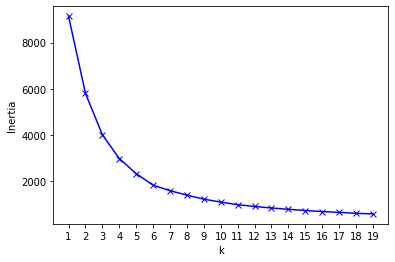

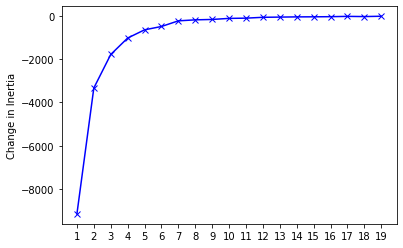

[9142.819884282795,
 5806.317801965931,
 4015.87735953007,
 2983.3810044985266,
 2329.8427412439214,
 1831.107162209721,
 1592.308290243845,
 1399.4100966746432,
 1225.1731211547594,
 1099.662156704527,
 984.9541970565191,
 909.4835726294834,
 843.4691999556462,
 787.166334886814,
 734.2872492044014,
 687.3567433694653,
 654.7519178353039,
 613.2432291029014,
 586.5761389365326]

In [69]:
plotKMeans(principalDf, 1, 20)

In [71]:
g,c = fitKMeans(principalDf, 13)

In [72]:
c

{0: Counter({'Post Malone': 4,
          'G-Eazy': 2,
          'Cardi B': 2,
          'Camila Cabello': 6,
          'Offset': 2,
          'Khalid': 6,
          'Dua Lipa': 1,
          '21 Savage': 2,
          'Selena Gomez': 4,
          'Kendrick Lamar': 2,
          'A$AP Ferg': 1,
          'Logic': 4,
          'Kodak Black': 1,
          'Maroon 5': 3,
          'Bebe Rexha': 2,
          'Marshmello': 2,
          'Hailee Steinfeld': 1,
          'NF': 3,
          'Halsey': 3,
          'Ed Sheeran': 1,
          'Imagine Dragons': 2,
          'Sam Smith': 2,
          'Eminem': 2,
          'Drake': 8,
          'The Chainsmokers': 6,
          'Taylor Swift': 6,
          'XXXTENTACION': 4,
          'J Balvin': 2,
          'A Boogie Wit da Hoodie': 2,
          '6ix9ine': 2,
          'Future': 3,
          'DJ Khaled': 1,
          'Big Sean': 2,
          'Zedd': 1,
          'Shawn Mendes': 2,
          'BTS': 4,
          'Playboi Carti': 1,
          'Rich The K

In [73]:
gc, cc = getClusterGenres(c, artist_data)

ToKeith is not in artist_data
Bob"Boris" Pickett is not in artist_data
BobHelms is not in artist_data
BaKeem is not in artist_data
Yung Anime is not in artist_data
Lil Monet is not in artist_data
Lil Adrei is not in artist_data
The 7 Dimensions is not in artist_data
GabBarrett is not in artist_data
Ray Parker, Jr. is not in artist_data
The Black Eyed Peas is not in artist_data


In [74]:
cc

{0: [('pop', 247)],
 1: [('rap', 268)],
 2: [('pop', 77)],
 3: [('rap', 271)],
 4: [('rap', 18)],
 5: [('pop', 200)],
 6: [('rap', 211)],
 7: [('pop', 163)],
 8: [('pop', 255)],
 9: [('pop', 153)],
 10: [('pop', 220)],
 11: [('pop', 113)],
 12: [('rap', 170)]}

In [75]:
gc

{0: {'adult standards': 5,
  'country': 10,
  'edm': 27,
  'hip hop': 101,
  'house': 31,
  'indie': 17,
  'latin': 5,
  'other': 7,
  'pop': 247,
  'r&b': 16,
  'rap': 147,
  'rock': 31,
  'trap': 76},
 1: {'adult standards': 4,
  'country': 12,
  'edm': 13,
  'hip hop': 187,
  'house': 14,
  'indie': 22,
  'latin': 4,
  'other': 5,
  'pop': 255,
  'r&b': 26,
  'rap': 268,
  'rock': 25,
  'trap': 167},
 2: {'adult standards': 19,
  'country': 3,
  'hip hop': 29,
  'indie': 10,
  'other': 9,
  'pop': 77,
  'r&b': 18,
  'rap': 39,
  'rock': 12,
  'trap': 9},
 3: {'adult standards': 2,
  'country': 12,
  'edm': 9,
  'hip hop': 198,
  'house': 11,
  'indie': 11,
  'latin': 9,
  'other': 2,
  'pop': 245,
  'r&b': 10,
  'rap': 271,
  'rock': 20,
  'trap': 172},
 4: {'adult standards': 1,
  'edm': 1,
  'hip hop': 14,
  'indie': 3,
  'latin': 1,
  'other': 3,
  'pop': 16,
  'r&b': 3,
  'rap': 18,
  'rock': 4,
  'trap': 14},
 5: {'adult standards': 12,
  'country': 17,
  'edm': 10,
  'hip hop'

In [76]:
cluster_genre_counts_raw

{0: {'adult standards': 8,
  'country': 10,
  'edm': 3,
  'hip hop': 59,
  'house': 3,
  'indie': 14,
  'latin': 1,
  'other': 7,
  'pop': 141,
  'r&b': 23,
  'rap': 84,
  'rock': 18,
  'trap': 38},
 1: {'adult standards': 8,
  'country': 11,
  'edm': 16,
  'hip hop': 107,
  'house': 19,
  'indie': 10,
  'latin': 31,
  'other': 11,
  'pop': 212,
  'r&b': 8,
  'rap': 155,
  'rock': 32,
  'trap': 91},
 2: {'adult standards': 1,
  'country': 11,
  'edm': 23,
  'hip hop': 105,
  'house': 28,
  'indie': 14,
  'latin': 2,
  'other': 10,
  'pop': 244,
  'r&b': 30,
  'rap': 168,
  'rock': 31,
  'trap': 79},
 3: {'adult standards': 32,
  'country': 11,
  'edm': 3,
  'hip hop': 55,
  'house': 6,
  'indie': 14,
  'other': 7,
  'pop': 149,
  'r&b': 24,
  'rap': 74,
  'rock': 17,
  'trap': 23,
  'latin': 0},
 4: {'adult standards': 1,
  'country': 6,
  'edm': 9,
  'hip hop': 52,
  'house': 17,
  'indie': 9,
  'latin': 1,
  'other': 8,
  'pop': 93,
  'r&b': 10,
  'rap': 91,
  'rock': 26,
  'trap': 2